# 1. Importing Libraries and Data

Importing the relevant libraries and the cleaned dataset.

In [2]:
import pandas as pd
from datetime import date, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from IPython.display import display
from IPython.display import Image
from sklearn.externals.six import StringIO 
from subprocess import call

import warnings
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.regularizers import l2

from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.ensemble import StackingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import tree
from sklearn.tree import export_graphviz
from pickle import dump

from Classes2 import Classification
# from Classes2 import Ensemble

pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data/data_cleaned6.csv')

The class distribution is checked to ensure that there is a balanced number of winners on both the fighter_x and fighter_y sides. This is already approximately a 50/50 split.

In [4]:
df.fx_win.value_counts(normalize=True)

1    0.500762
0    0.499238
Name: fx_win, dtype: float64

In [5]:
df.head()

,name_x,height_x,weight_x,reach_x,fx_win,age_x,height_x.1,weight_x.1,reach_x.1,str_landed_per_min_x,str_acc_x,str_absorb_per_min_x,str_def_x,td_avg_x,td_acc_x,td_def_x,sub_avg_x,win_percentage_x,name_y,height_y,weight_y,reach_y,age_y,height_y.1,weight_y.1,reach_y.1,str_landed_per_min_y,str_acc_y,str_absorb_per_min_y,str_def_y,td_avg_y,td_acc_y,td_def_y,sub_avg_y,win_percentage_y,stance_x_Open Stance,stance_x_Orthodox,stance_x_Sideways,stance_x_Southpaw,stance_x_Switch,stance_y_Open Stance,stance_y_Orthodox,stance_y_Sideways,stance_y_Southpaw,stance_y_Switch
0,Aaron Phillips,1.75,135.0,1.78,0,25.05,1.75,135.0,1.78,7.27,0.80,6.33,0.74,0.00,0.00,0.62,1.00,0.89,Matt Hobar,1.78,135.0,1.78,27.63,1.78,135.0,1.78,2.52,0.26,9.71,0.59,0.00,0.0,1.0,0.00,0.80,0,0,0,1,0,0,0,0,1,0
1,Aaron Riley,1.73,155.0,1.75,0,25.10,1.73,155.0,1.75,6.20,0.55,5.80,0.49,0.00,0.00,0.75,1.00,0.72,Spencer Fisher,1.70,155.0,1.78,29.69,1.70,155.0,1.78,2.26,0.48,8.64,0.62,1.54,0.5,1.0,4.63,0.85,0,0,0,1,0,0,0,0,1,0
2,Aaron Riley,1.73,155.0,1.75,1,27.93,1.73,155.0,1.75,5.50,0.54,5.85,0.48,1.50,0.29,0.75,0.75,0.70,Jorge Gurgel,1.70,155.0,1.75,31.81,1.70,155.0,1.75,5.80,0.50,5.80,0.50,1.00,0.5,0.5,0.00,0.64,0,0,0,1,0,0,1,0,0,0
3,Aaron Riley,1.73,155.0,1.75,1,28.66,1.73,155.0,1.75,6.91,0.52,5.96,0.45,1.26,0.38,0.58,0.42,0.69,Shane Nelson,1.75,155.0,1.78,24.69,1.75,155.0,1.78,6.85,0.42,6.85,0.42,0.00,0.0,0.0,0.00,0.78,0,0,0,1,0,0,0,0,1,0
4,Aaron Riley,1.73,155.0,1.75,1,29.47,1.73,155.0,1.75,7.68,0.53,6.10,0.50,1.11,0.38,0.11,0.00,0.68,Joe Brammer,1.73,155.0,1.73,26.77,1.73,155.0,1.73,1.39,0.24,4.17,0.58,0.00,0.0,1.0,0.00,0.70,0,0,0,1,0,0,1,0,0,0


# 2. Data Transformations

In this section the data is transformed using the StandardScaler class. The scaling was fit to fighter_x and then used to transform the fighter_y data.

In [6]:
y = df[['fx_win']]

In [7]:
X = df.drop(columns=['fx_win','name_x','name_y'])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=400, random_state=50, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=50, stratify=y_train)

In [9]:
x_num_cols = [col for col in X.columns if '_x' in col and 'stance' not in col]
y_num_cols = [col for col in X.columns if '_y' in col and 'stance' not in col]

In [10]:
scaler = RobustScaler()

In [11]:
X_train[x_num_cols] = scaler.fit_transform(X_train[x_num_cols])
X_train[y_num_cols] = scaler.transform(X_train[y_num_cols])

X_val[x_num_cols] = scaler.transform(X_val[x_num_cols])
X_val[y_num_cols] = scaler.transform(X_val[y_num_cols])

X_test[x_num_cols] = scaler.transform(X_test[x_num_cols])
X_test[y_num_cols] = scaler.transform(X_test[y_num_cols])

The scaler was then saved to be used on the data in the web application.

In [12]:
dump(scaler, open('scaler.pkl', 'wb'))

# 3. Modelling

A stratified kfold with 5 splits was used for the cross validation of the models.

In [13]:
skf = StratifiedKFold(n_splits=5, random_state=50)

## 3.1. Logistic Regression

The first model tried was a logistic regression. This acts as a baseline for which other models will be compared to. The metric by which models will be assessed is the area under the ROC curve.

In [14]:
log_reg1 = Classification("Logistic Regression", X_train, X_val, y_train, y_val)

A grid search is completed which returns the best performing hyperparameters for the model.

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.6609,0.6579


The best hyperparameters are:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'} 



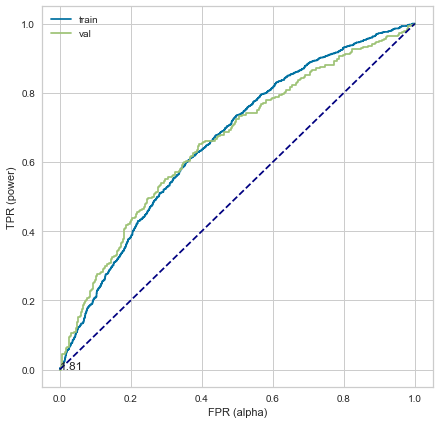

In [15]:
param_grid = {'C': [0.01,0.1,1,10,100],
             'penalty': ['l1','l2'],
             'solver': ['liblinear','saga']}
log_reg1.get_scores(param_grid, skf)

## 3.2. Support Vector Machine

In [ ]:
svm1 = Classification("SVM", X_train, X_val, y_train, y_val)

In [ ]:
param_grid = {'C':[1,2,3,4,5,6],
             'degree':[1,2,3,4,5,6],
             'gamma':['scale','auto'],
             'decision_function_shape':['ovo','ovr']}
svm1.get_scores(param_grid, skf)

## 3.3. Decision Tree

In [16]:
d_tree = Classification('Decision Tree', X_train, X_val, y_train, y_val)

,Model Name,Train AUC,Validation AUC
0,Decision Tree,0.83,0.6031


The best hyperparameters are:  {'max_depth': 10, 'min_samples_leaf': 10} 



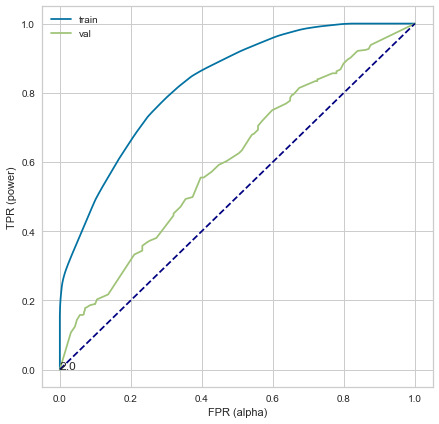

In [17]:
param_grid = {'max_depth':[1,10,100,1000],'min_samples_leaf':[1,10,100,1000]}
d_tree.get_scores(param_grid, skf)

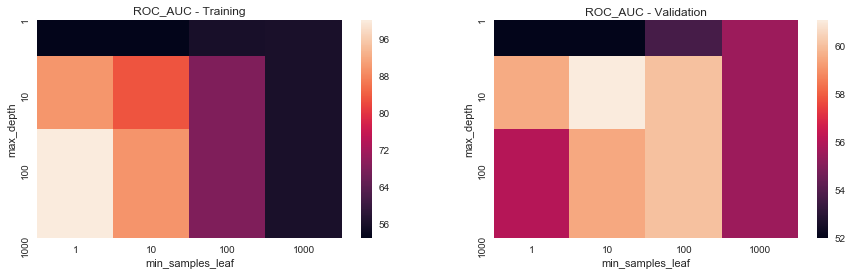

In [18]:
d_tree.opt_plots()

In [19]:
d_tree4 = DecisionTreeClassifier(max_depth=6, min_samples_leaf=31, random_state=50)

In [20]:
d_tree4.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=31, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=50, splitter='best')

In [21]:
val_prob = d_tree4.predict_proba(X_val)[:,1]

In [22]:
val_auc = roc_auc_score(y_val, val_prob)

In [23]:
val_auc

0.6564856561465108

In [24]:
d_tree2 = Classification('Decision Tree', X_train, X_val, y_train, y_val)

,Model Name,Train AUC,Validation AUC
0,Decision Tree,0.7005,0.6565


The best hyperparameters are:  {'max_depth': 6, 'min_samples_leaf': 31} 



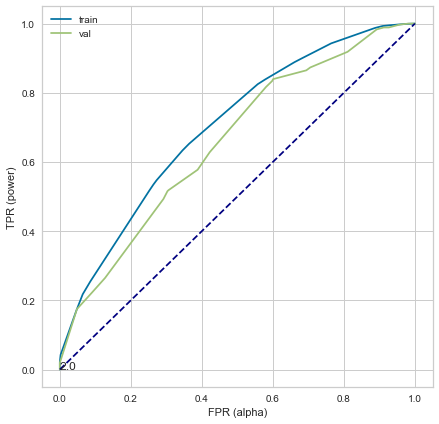

In [25]:
param_grid = {'max_depth':range(1,101,5),'min_samples_leaf':range(1,101,5)}
d_tree2.get_scores(param_grid, skf)

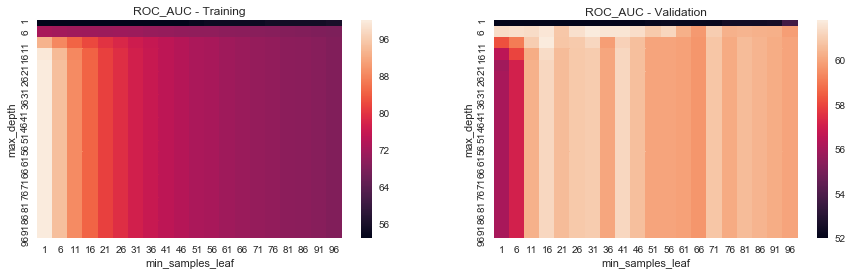

In [26]:
d_tree2.opt_plots()

In [27]:
d_tree3 = Classification('Decision Tree', X_train, X_val, y_train, y_val)

,Model Name,Train AUC,Validation AUC
0,Decision Tree,0.7653,0.6187


The best hyperparameters are:  {'max_depth': 8, 'min_samples_leaf': 18} 



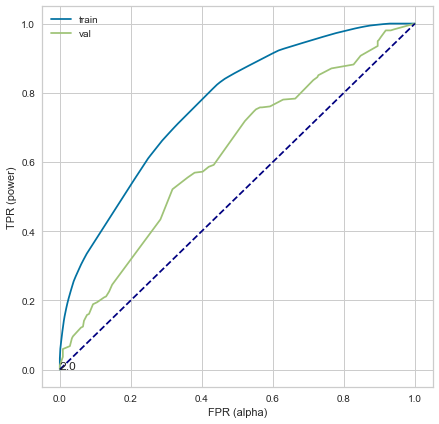

In [28]:
param_grid = {'max_depth':range(1,15,1),'min_samples_leaf':range(10,50,1)}
d_tree3.get_scores(param_grid, skf)

In [29]:
d_tree3.best_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=18, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [30]:
d_tree3.opt_model.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=18, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [31]:
d_tree3.opt_model

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=50, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
           

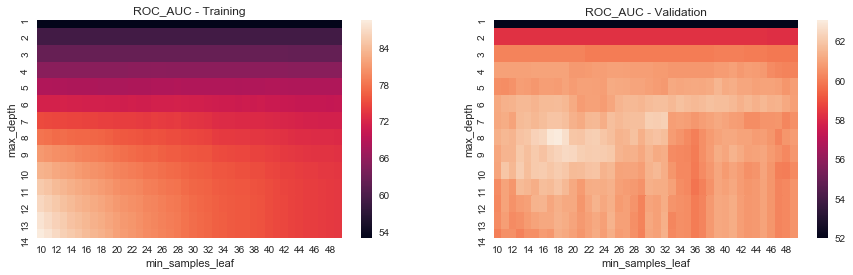

In [32]:
d_tree3.opt_plots()

## 3.4. Random Forest

In [ ]:
rand_forr = Classification("Random Forest", X_train, X_val, y_train, y_val)

In [ ]:
param_grid = {'max_depth':[1,10,100,1000],'min_samples_leaf':[1,10,100,1000]}
rand_forr.get_scores(param_grid, skf)

In [ ]:
rand_forr.opt_plots()

In [ ]:
rand_forr2 = Classification("Random Forest", X_train, X_val, y_train, y_val)

In [ ]:
param_grid = {'max_depth':range(10,11,1),'min_samples_leaf':range(1,2,1)}
rand_forr2.get_scores(param_grid, skf)

In [ ]:
rand_forr2.opt_plots()

## 3.5. Voing Classifier

In [ ]:
svm = ('svm', svm1.best_model)
rand_forr = ('rand_forr', rand_forr3.best_model)
estimators = [svm, rand_forr]
voting = Ensemble("Voting", estimators, X_train, X_val, y_train, y_val)

In [ ]:
voting.ensemble_get_scores({}, skf)

## 3.6. Adaboost

In [ ]:
estimators = rand_forr3.best_model
adaboost = Ensemble("AdaBoost", estimators, X_train, X_val, y_train, y_val)

In [ ]:
adaboost.ensemble_get_scores({}, skf)

## 3.7. XGBoost

In [ ]:
estimators = []
xgboost = Ensemble("XGBoost", estimators, X_train, X_val, y_train, y_val)

In [ ]:
xgboost.ensemble_get_scores({}, skf)

## 3.8. Stacking Classifier

In [ ]:
estimators = [('svm', svm1.best_model), 
              ('rnd', rand_forr3.best_model),
              ('voting', voting.best_model)]
stacking = Ensemble("Stacking", estimators, X_train, X_val, y_train, y_val)

In [ ]:
stacking.ensemble_get_scores({}, skf)

In [ ]:
stacking.best_model.score(X_test, y_test)

## 3.9. Deep Neural Network

In [ ]:
l2_reg = keras.regularizers.l2(0.0001)

In [ ]:
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_dim=X_train.shape[1], kernel_initializer='normal', 
                 kernel_regularizer=l2_reg))
model2.add(Dropout(rate=0.1))
model2.add(Dense(64, activation='relu', kernel_initializer='normal', kernel_regularizer=l2_reg))
model2.add(Dropout(rate=0.1))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.summary()

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(X_train, y_train, epochs=40, batch_size=16, validation_data=(X_val, y_val))

In [ ]:
pd.DataFrame(history2.history).plot(figsize=(15,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
y_pred = model2.predict(X_test)

In [ ]:
model2.evaluate(X_val, y_val)

# 4. Model Evaluation

In [ ]:
model_evaluation_list = [log_reg1.scores_table,
                         svm1.scores_table, 
                         d_tree3.scores_table, 
                         rand_forr3.scores_table,
                         voting.scores_table,
                         adaboost.scores_table,
                         xgboost.scores_table,
                         stacking.scores_table]

model_names = ['logistic_regression',
               'svm',
               'decision_tree',
               'random_forest',
               'voting',
               'adaboost (random forest)',
               'xgboost',
               'stacking (svm, random forest, xgboost)']

In [ ]:
df_evaluation = pd.concat(model_evaluation_list)

In [ ]:
dump(stacking.best_model, open('model.pkl', 'wb'))